In [1]:
# ------------------  set up logging ----------------------
import logging
from auditory_cortex.utils import set_up_logging
set_up_logging()

import os
from scipy import stats
from scipy.stats import mannwhitneyu
import numpy as np
import matplotlib.pyplot as plt
from auditory_cortex.neural_data import NormalizerCalculator
from auditory_cortex.neural_data import create_neural_metadata, create_neural_dataset
from auditory_cortex import results_dir
from auditory_cortex.plotters.plotter_utils import PlotterUtils

In [2]:
dataset_name = 'ucsf'
metadata = create_neural_metadata(dataset_name)
sessions = metadata.get_all_available_sessions()
norm_obj = NormalizerCalculator(dataset_name)

In [3]:
# read all the normalizer and null distributions
bin_width = 20
mVocs = False
p_value = 0.05
tuned_channels = []
all_p_values = []
highly_tuned_channels = []
session_null_dist = {}
session_norm_dist = {}
for session in sessions:
    shifted_null = norm_obj.get_normalizer_null_dist_using_random_shifts(
        session, bin_width=bin_width, mVocs=mVocs, force_redo=False
    )
    norm_dist = norm_obj.get_normalizer_for_session(
        session, bin_width=bin_width, mVocs=mVocs
    ) 
    session_null_dist[session] = shifted_null
    session_norm_dist[session] = norm_dist
#     for ch in range(shifted_null.shape[1]):
#         dist1 = norm_dist[:,ch]
#         dist2 = shifted_null[:,ch]
#         stat, p = mannwhitneyu(dist1, dist2, alternative='greater')  # dist1 > dist2
#         all_p_values.append(p)
#         if p < p_value:
#             tuned_channels.append(f'{session}-{ch:02d}')
#         thresh = np.percentile(dist2, 85)
#         if np.median(dist1) > thresh:
#             highly_tuned_channels.append(f'{session}-{ch:02d}')

# all_p_values = np.array(all_p_values)    

INFO:Getting normalizer dist. for sess-180413, bw-20, mVocs=False
INFO:Getting normalizer dist. for sess-180420, bw-20, mVocs=False
INFO:Getting normalizer dist. for sess-180501, bw-20, mVocs=False
INFO:Getting normalizer dist. for sess-180502, bw-20, mVocs=False
INFO:Getting normalizer dist. for sess-180613, bw-20, mVocs=False
INFO:Getting normalizer dist. for sess-180622, bw-20, mVocs=False
INFO:Getting normalizer dist. for sess-180627, bw-20, mVocs=False
INFO:Getting normalizer dist. for sess-180717, bw-20, mVocs=False
INFO:Getting normalizer dist. for sess-180719, bw-20, mVocs=False
INFO:Getting normalizer dist. for sess-180720, bw-20, mVocs=False
INFO:Getting normalizer dist. for sess-180724, bw-20, mVocs=False
INFO:Getting normalizer dist. for sess-180728, bw-20, mVocs=False
INFO:Getting normalizer dist. for sess-180730, bw-20, mVocs=False
INFO:Getting normalizer dist. for sess-180731, bw-20, mVocs=False
INFO:Getting normalizer dist. for sess-180807, bw-20, mVocs=False
INFO:Getti

### highly-tuned at different gaps

In [4]:
# identify tuned neurons at different thresholds

tuned_channels = []
all_p_values = []
highly_tuned_channels = []

std_deviations_away = np.linspace(0, 2.5, 26)
total_highly_tuned = {s:0 for s in std_deviations_away}
total_highly_tuned_medians = {s:0 for s in std_deviations_away}
for session in sessions:
    norm_dist = session_norm_dist[session]
    shifted_null = session_null_dist[session]

    norm_means = np.mean(norm_dist, axis=0)
    null_means = np.mean(shifted_null, axis=0)

    norm_medians = np.median(norm_dist, axis=0)
    null_medians = np.median(shifted_null, axis=0)

    null_std = np.std(shifted_null, axis=0)

    for s in std_deviations_away:
        thresh = null_means + (s * null_std)
        highly_tuned = np.where(norm_means > thresh)[0]
        total_highly_tuned[s] += len(highly_tuned)

        thresh = null_medians + (s * null_std)
        highly_tuned = np.where(norm_medians > thresh)[0]
        total_highly_tuned_medians[s] += len(highly_tuned)


result saved at: /depot/jgmakin/data/auditory_cortex/results/tikz_plots/highly-tuned-channels--bw-20-timit.tex


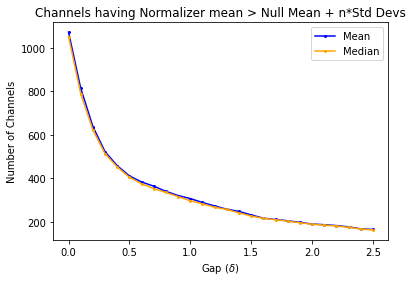

In [5]:
# plt.figure(figsize=(2.5, 3))
plt.plot(
    std_deviations_away, [total_highly_tuned[s] for s in std_deviations_away], marker='o', ms=2,
    color='blue', label='Mean'
    )
plt.plot(
    std_deviations_away, [total_highly_tuned_medians[s] for s in std_deviations_away], marker='o', ms=2,
    color='orange', label='Median'
    )
# plt.xticks(std_deviations_away[::2])
plt.xlabel('Gap ($\delta$)')
plt.ylabel('Number of Channels')
plt.title('Channels having Normalizer mean > Null Mean + n*Std Devs')
plt.legend()
# # get rid of the bounding boxes...
# ax.spines['top'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.spines['left'].set_visible(False)


if mVocs:
    stim = 'mVocs'
else:
    stim = 'timit'
filepath = os.path.join(
    results_dir,
    'tikz_plots',
    f"highly-tuned-channels--bw-{bin_width}-{stim}.tex"
    )
PlotterUtils.save_tikz(filepath)

result saved at: /depot/jgmakin/data/auditory_cortex/results/tikz_plots/norm-dist-tuned-200206-60.tex


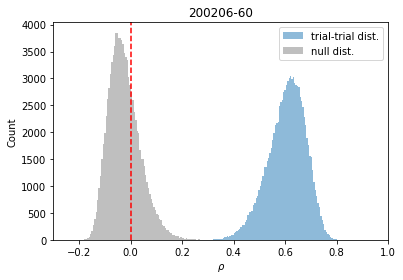

result saved at: /depot/jgmakin/data/auditory_cortex/results/tikz_plots/norm-dist-tuned-200318-30.tex


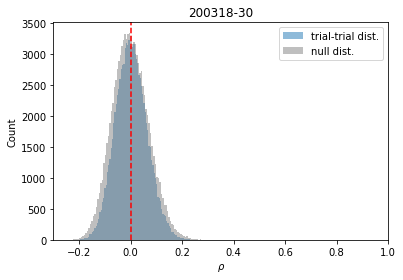

result saved at: /depot/jgmakin/data/auditory_cortex/results/tikz_plots/norm-dist-tuned-180720-4.tex


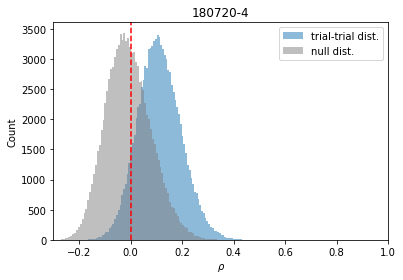

result saved at: /depot/jgmakin/data/auditory_cortex/results/tikz_plots/norm-dist-tuned-180501-8.tex


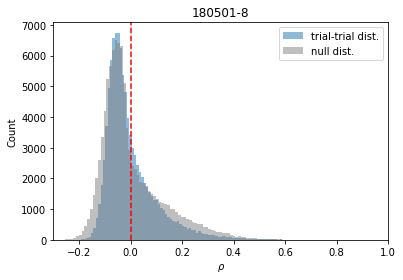

In [121]:
tuned_sess_channels = {
    '200206': [60],
    '200318': [30],
    '180720': [4],
    '180501': [8],
}
alpha = 0.5
bins = 100
for sess in tuned_sess_channels.keys():
    channels = tuned_sess_channels[sess]
    for ch in channels:
        # plt.figure(figsize=(2, 2.5))
        plt.hist(session_norm_dist[sess][:,ch], color='tab:blue', alpha=alpha, bins=bins, label='trial-trial dist.')
        plt.hist(session_null_dist[sess][:,ch], color='gray', alpha=alpha, bins=bins, label='null dist.')

        plt.axvline(0.0, color='red', linestyle='--')

        plt.xlim(-0.3, 1.0)
        plt.title(f'{sess}-{ch}')
        plt.xlabel(f"$\\rho$")
        plt.ylabel('Count')
        plt.legend()
        filepath = os.path.join(
            results_dir,
            'tikz_plots',
            f"norm-dist-tuned-{sess}-{ch}.tex"
            )
        PlotterUtils.save_tikz(filepath)
        plt.show()

result saved at: /depot/jgmakin/data/auditory_cortex/results/tikz_plots/norm-dist-not-tuned-180724-5.tex


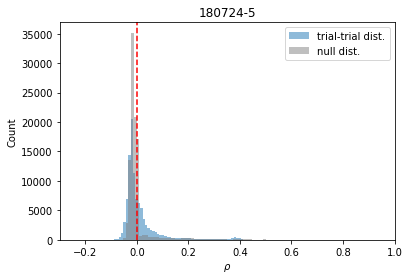

result saved at: /depot/jgmakin/data/auditory_cortex/results/tikz_plots/norm-dist-not-tuned-180627-2.tex


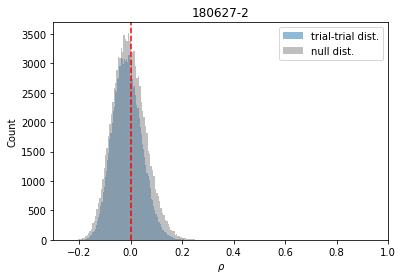

result saved at: /depot/jgmakin/data/auditory_cortex/results/tikz_plots/norm-dist-not-tuned-190605-10.tex


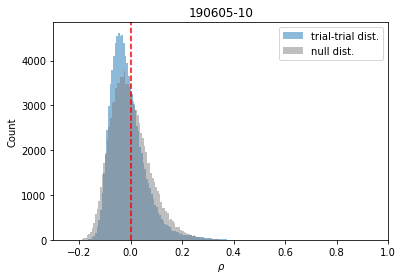

In [122]:
tuned_sess_channels = {
    '180724': [5],  # came out highly tuned using means at 0.1 sd gap
    '180627': [2],
    '190605': [10],
    
}
alpha = 0.5
bins = 100
for sess in tuned_sess_channels.keys():
    channels = tuned_sess_channels[sess]
    for ch in channels:
        plt.hist(session_norm_dist[sess][:,ch], color='tab:blue', alpha=alpha, bins=bins, label='trial-trial dist.')
        plt.hist(session_null_dist[sess][:,ch], color='gray', alpha=alpha, bins=bins, label='null dist.')
        plt.axvline(0.0, color='red', linestyle='--')
        
        plt.xlim(-0.3, 1.0)
        plt.title(f'{sess}-{ch}')
        plt.xlabel(f"$\\rho$")
        plt.ylabel('Count')
        plt.legend()
        filepath = os.path.join(
            results_dir,
            'tikz_plots',
            f"norm-dist-not-tuned-{sess}-{ch}.tex"
            )
        PlotterUtils.save_tikz(filepath)
        plt.show()

### tuned neurons

In [22]:
p_value = 0.05
all_p_values = []
session_wise_tuned_channels = {}
for session in sessions:    
    shifted_null = session_null_dist[session]
    norm_dist = session_norm_dist[session]
    tuned_channels = []
    for ch in range(shifted_null.shape[1]):
        dist1 = norm_dist[:,ch]
        dist2 = shifted_null[:,ch]
        stat, p = mannwhitneyu(dist1, dist2, alternative='greater')  # dist1 > dist2
        all_p_values.append(p)
        if p < p_value:
            tuned_channels.append(ch)
    session_wise_tuned_channels[session] = tuned_channels
all_p_values = np.array(all_p_values)  

In [ ]:
session_wise_tuned_count = {session: len(session_wise_tuned_channels[session]) for session in sessions}
for session in sessions:
    print(f"session: {session}, sig: {session_wise_tuned_count[session]}/{session_null_dist[session].shape[1]}")

session: 180413, sig: 10/16
session: 180420, sig: 16/16
session: 180501, sig: 16/16
session: 180502, sig: 13/16
session: 180613, sig: 12/16
session: 180622, sig: 12/16
session: 180627, sig: 7/16
session: 180717, sig: 6/16
session: 180719, sig: 13/16
session: 180720, sig: 16/16
session: 180724, sig: 9/16
session: 180728, sig: 11/16
session: 180730, sig: 12/16
session: 180731, sig: 16/16
session: 180807, sig: 15/16
session: 180808, sig: 14/16
session: 180810, sig: 16/16
session: 180814, sig: 34/36
session: 190604, sig: 29/64
session: 190605, sig: 18/64
session: 190606, sig: 59/64
session: 190703, sig: 25/64
session: 190726, sig: 42/60
session: 190801, sig: 48/64
session: 191113, sig: 55/60
session: 191115, sig: 55/58
session: 191121, sig: 40/63
session: 191125, sig: 46/60
session: 191206, sig: 47/61
session: 191209, sig: 34/59
session: 191210, sig: 53/61
session: 191211, sig: 13/61
session: 191219, sig: 38/62
session: 200205, sig: 48/60
session: 200206, sig: 64/64
session: 200207, sig: 3

In [31]:
session = '190605'
print(f"Total channels: {session_null_dist[session].shape[1]}")
print(f"Tuned channels: {session_wise_tuned_count[session]}")
print(f"Tuned channels: {session_wise_tuned_channels[session]}")

Total channels: 64
Tuned channels: 18
Tuned channels: [3, 5, 7, 8, 13, 15, 17, 24, 25, 27, 31, 34, 39, 40, 41, 43, 44, 48]


In [46]:
session = '180627'
print(f"Total channels: {session_null_dist[session].shape[1]}")
print(f"Tuned channels: {session_wise_tuned_count[session]}")
print(f"Tuned channels: {session_wise_tuned_channels[session]}")

Total channels: 16
Tuned channels: 7
Tuned channels: [0, 3, 5, 6, 9, 10, 15]


In [32]:
session = '200318'
ch = 32
session_wise_tuned_channels[session]

[0, 1, 4, 11, 14, 15, 16, 22, 29, 30, 31, 33, 36]

In [44]:
session = '180720'
session_wise_tuned_channels[session]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

In [69]:
# identify tuned neurons at different thresholds

tuned_channels = []
all_p_values = []

gap = 0.3
sess_highly_tuned_means = {}
sess_highly_tuned_medians = {}

total_highly_tuned_means = {gap: 0}
total_highly_tuned_medians = {gap: 0}

total_ht_not_tuned_means = 0
total_ht_not_tuned_medians = 0
for session in sessions:
    norm_dist = session_norm_dist[session]
    shifted_null = session_null_dist[session]

    norm_means = np.mean(norm_dist, axis=0)
    null_means = np.mean(shifted_null, axis=0)

    norm_medians = np.median(norm_dist, axis=0)
    null_medians = np.median(shifted_null, axis=0)

    null_std = np.std(shifted_null, axis=0)

    thresh = null_means + (gap * null_std)
    highly_tuned = np.where(norm_means > thresh)[0]
    total_highly_tuned_means[gap] += len(highly_tuned)
    sess_highly_tuned_means[session] = highly_tuned

    thresh = null_medians + (gap * null_std)
    highly_tuned = np.where(norm_medians > thresh)[0]
    total_highly_tuned_medians[gap] += len(highly_tuned)
    sess_highly_tuned_medians[session] = highly_tuned

    tuned = session_wise_tuned_channels[session]
    ht_means = sess_highly_tuned_means[session]
    ht_medians = sess_highly_tuned_medians[session]

    ht_but_not_tuned_means = np.setdiff1d(ht_means, tuned)
    ht_but_not_tuned_medians = np.setdiff1d(ht_medians, tuned)

    if len(ht_but_not_tuned_means) > 0:
        print(f"session: {session}, ht but not tuned (means): {ht_but_not_tuned_means}")
    if len(ht_but_not_tuned_medians) > 0:
        print(f"session: {session}, ht but not tuned (medians): {ht_but_not_tuned_medians}")

    total_ht_not_tuned_means += len(ht_but_not_tuned_means)
    total_ht_not_tuned_medians += len(ht_but_not_tuned_medians)

print(f"For gap: {gap}")
print(f"Highly tuned (means): {total_highly_tuned_means[gap]}")
print(f"Highly tuned (medians): {total_highly_tuned_medians[gap]}")
print(f"Highly tuned but not tuned channels (means): {total_ht_not_tuned_means}")
print(f"Highly tuned but not tuned channels (medians): {total_ht_not_tuned_medians}")


For gap: 0.3
Highly tuned (means): 498
Highly tuned (medians): 537
Highly tuned but not tuned channels (means): 0
Highly tuned but not tuned channels (medians): 0


In [94]:
# identify tuned neurons at different thresholds

tuned_channels = []
all_p_values = []

gap = 0.1
total_highly_tuned_means = {gap: 0}
total_highly_tuned_medians = {gap: 0}

total_ht_not_tuned_means = 0
total_ht_not_tuned_medians = 0
for session in sessions:
    norm_dist = session_norm_dist[session]
    shifted_null = session_null_dist[session]

    norm_means = np.mean(norm_dist, axis=0)
    null_means = np.mean(shifted_null, axis=0)

    norm_medians = np.median(norm_dist, axis=0)
    null_medians = np.median(shifted_null, axis=0)

    null_std = np.std(shifted_null, axis=0)

    thresh = null_means + (gap * null_std)
    highly_tuned = np.where(norm_means > thresh)[0]
    total_highly_tuned_means[gap] += len(highly_tuned)
    sess_highly_tuned_means[session] = highly_tuned

    thresh = null_medians + (gap * null_std)
    highly_tuned = np.where(norm_medians > thresh)[0]
    total_highly_tuned_medians[gap] += len(highly_tuned)
    sess_highly_tuned_medians[session] = highly_tuned

    tuned = session_wise_tuned_channels[session]
    ht_means = sess_highly_tuned_means[session]
    ht_medians = sess_highly_tuned_medians[session]

    ht_but_not_tuned_means = np.setdiff1d(ht_means, tuned)
    ht_but_not_tuned_medians = np.setdiff1d(ht_medians, tuned)

    if len(ht_but_not_tuned_means) > 0:
        print(f"sess-{session}: highly tuned (means) but not tuned: {ht_but_not_tuned_means}")
    if len(ht_but_not_tuned_medians) > 0:
        print(f"sess-{session}: highly tuned (means) but not tuned: {ht_but_not_tuned_medians}")

    total_ht_not_tuned_means += len(ht_but_not_tuned_means)
    total_ht_not_tuned_medians += len(ht_but_not_tuned_medians)

print(f"For gap: {gap}")
print(f"Highly tuned (means): {total_highly_tuned_means[gap]}")
print(f"Highly tuned (medians): {total_highly_tuned_medians[gap]}")
print(f"Highly tuned but not tuned channels (means): {total_ht_not_tuned_means}")
print(f"Highly tuned but not tuned channels (medians): {total_ht_not_tuned_medians}")


sess-180724: highly tuned (means) but not tuned: [5]
For gap: 0.1
Highly tuned (means): 763
Highly tuned (medians): 866
Highly tuned but not tuned channels (means): 1
Highly tuned but not tuned channels (medians): 0


### exploring weekly tuned neurons..

In [ ]:
# identify tuned neurons at different thresholds

tuned_channels = []
all_p_values = []

gaps = [0.1, 0.3]
total_highly_tuned_means = {gap: 0 for gap in gaps}
total_highly_tuned_medians = {gap: 0 for gap in gaps}

sess_highly_tuned_means = {gap: {} for gap in gaps}

total_ht_not_tuned_means = 0
total_ht_not_tuned_medians = 0
for session in sessions:
    norm_dist = session_norm_dist[session]
    shifted_null = session_null_dist[session]

    norm_means = np.mean(norm_dist, axis=0)
    null_means = np.mean(shifted_null, axis=0)

    norm_medians = np.median(norm_dist, axis=0)
    null_medians = np.median(shifted_null, axis=0)

    null_std = np.std(shifted_null, axis=0)

    for gap in gaps:
        thresh = null_means + (gap * null_std)
        highly_tuned = np.where(norm_means > thresh)[0]
        total_highly_tuned_means[gap] += len(highly_tuned)
        sess_highly_tuned_means[gap][session] = highly_tuned


In [97]:
total_highly_tuned_means

{0.1: 763, 0.3: 498}

In [102]:
weekly_tuned_sess_channels = {}
gaps_to_check = [0.1, 0.3]
ht_gap1 = sess_highly_tuned_means[gaps_to_check[0]]
ht_gap2 = sess_highly_tuned_means[gaps_to_check[1]]
total_weekly_tuned = 0
for sess in sessions:
    weekly_tuned_sess_channels[sess] = np.setdiff1d(ht_gap1[sess], ht_gap2[sess])
    total_weekly_tuned += len(weekly_tuned_sess_channels[sess])
print(f"Total weekly tuned channels: {total_weekly_tuned}")

Total weekly tuned channels: 265


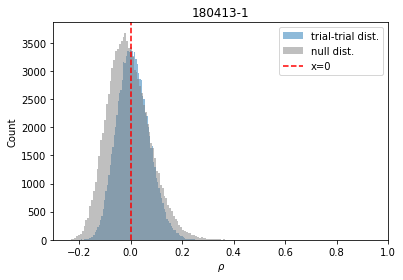

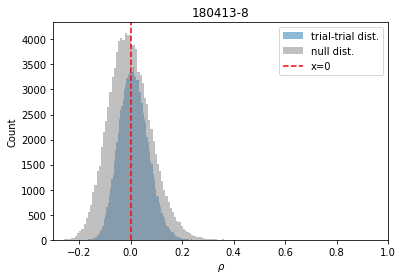

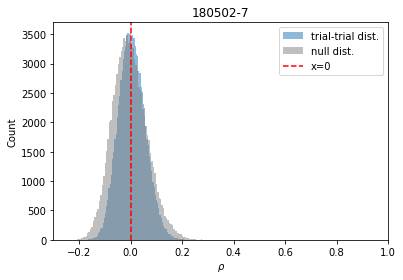

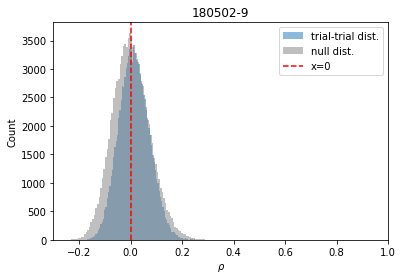

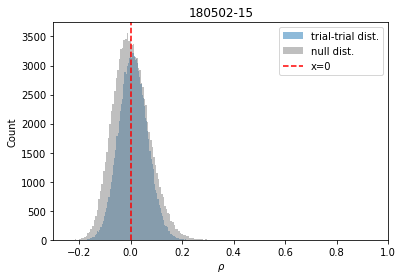

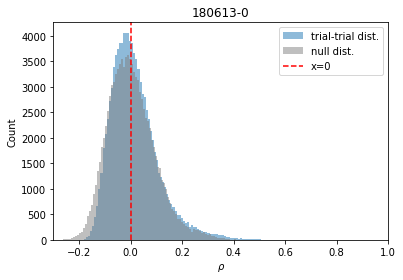

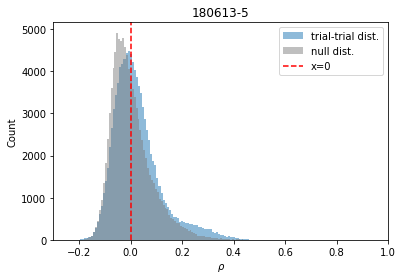

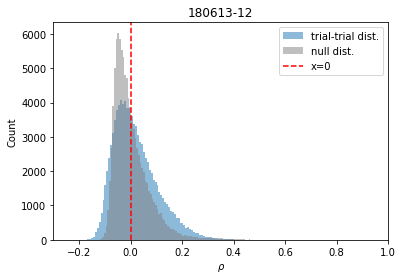

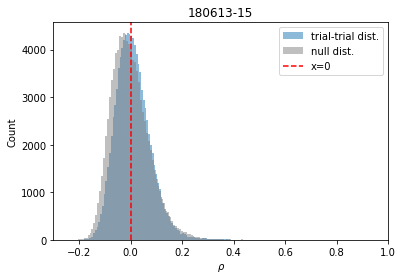

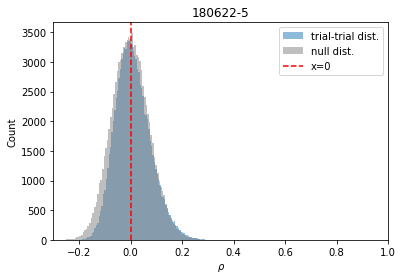

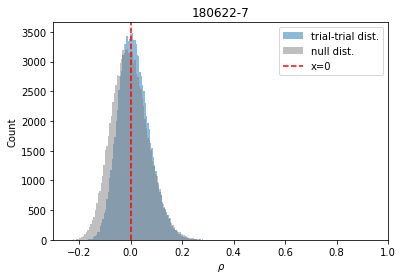

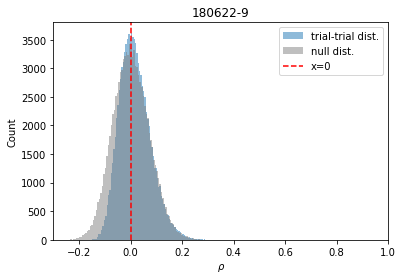

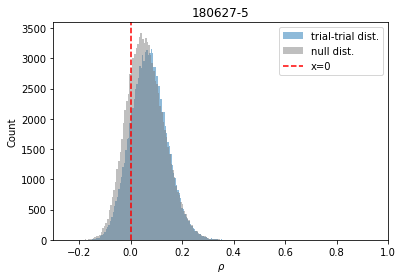

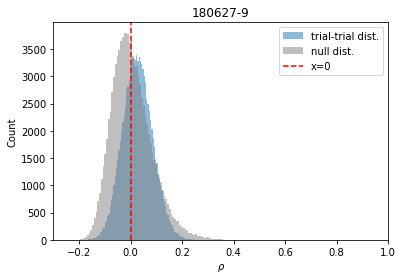

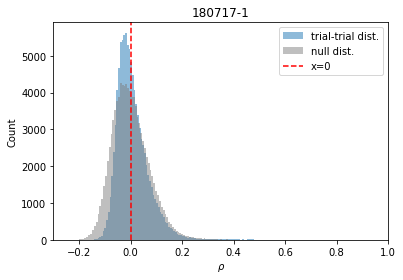

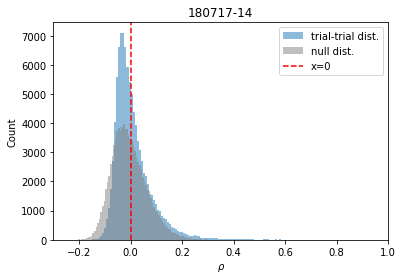

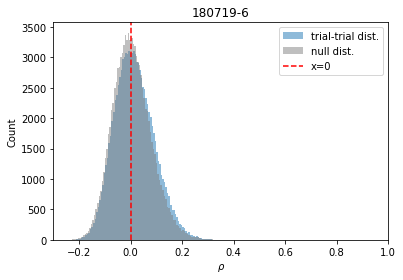

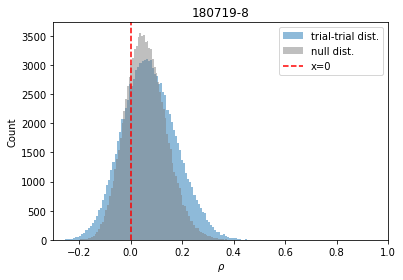

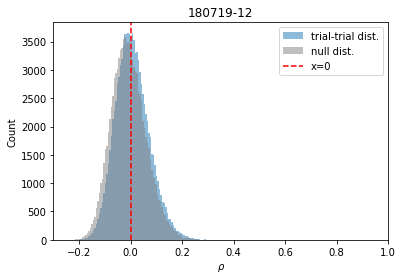

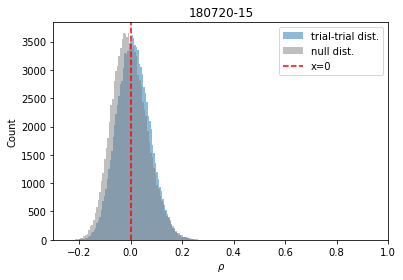

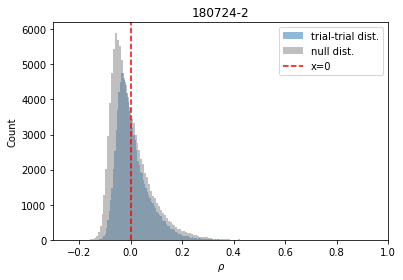

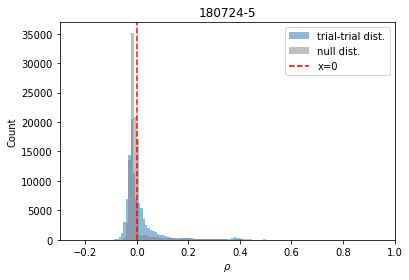

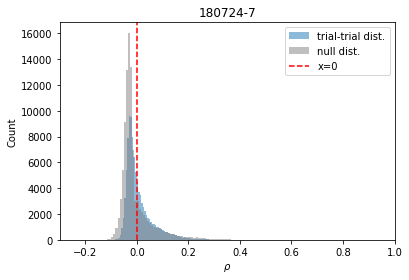

In [106]:
sess_channel_dict = weekly_tuned_sess_channels
alpha = 0.5
bins = 100
total = 0
for sess in sess_channel_dict.keys():
    channels = sess_channel_dict[sess]
    if len(channels) == 0:
        continue
    for ch in channels:
        plt.hist(session_norm_dist[sess][:,ch], color='tab:blue', alpha=alpha, bins=bins, label='trial-trial dist.')
        plt.hist(session_null_dist[sess][:,ch], color='gray', alpha=alpha, bins=bins, label='null dist.')
        plt.axvline(x=0.0, color='red', linestyle='--', label='x=0')
        plt.xlim(-0.3, 1.0)
        plt.title(f'{sess}-{ch}')
        plt.xlabel(f"$\\rho$")
        plt.ylabel('Count')
        plt.legend()
        plt.show()
        total += 1

    if total > 20:
        break

In [112]:
weekly_tuned_sess_channels['180501']

array([], dtype=int64)

### distributions at different gaps..

In [4]:
# identify tuned neurons at different thresholds

tuned_channels = []
all_p_values = []
highly_tuned_channels = []


std_deviations_away = [0.1, 0.3, 1.0]
total_highly_tuned = {s:0 for s in std_deviations_away}
total_highly_tuned_medians = {s:0 for s in std_deviations_away}
sess_highly_tuned_means = {s:{} for s in std_deviations_away}
sess_highly_tuned_medians = {s:{} for s in std_deviations_away}

for session in sessions:
    norm_dist = session_norm_dist[session]
    shifted_null = session_null_dist[session]

    norm_means = np.mean(norm_dist, axis=0)
    null_means = np.mean(shifted_null, axis=0)

    norm_medians = np.median(norm_dist, axis=0)
    null_medians = np.median(shifted_null, axis=0)

    null_std = np.std(shifted_null, axis=0)

    for s in std_deviations_away:
        thresh = null_means + (s * null_std)
        diff = np.abs(norm_means - thresh)
        highly_tuned = np.where(diff<0.01)[0]
        total_highly_tuned[s] += len(highly_tuned)
        sess_highly_tuned_means[s][session] = highly_tuned

        thresh = null_medians + (s * null_std)
        diff = np.abs(norm_medians - thresh)
        highly_tuned = np.where(diff<0.01)[0]
        total_highly_tuned_medians[s] += len(highly_tuned)
        sess_highly_tuned_medians[s][session] = highly_tuned


In [5]:
total_highly_tuned

{0.1: 692, 0.3: 239, 1.0: 50}

In [6]:
gaps = [1.0]
selected_sess_ch = {}
sess_ch_gaps = {}
for gap in gaps:
    while(True):
        try:
            rand_sess = np.random.choice(list(sess_highly_tuned_means[gap].keys()))
            rand_ch = np.random.choice(sess_highly_tuned_means[gap][rand_sess])
            break
        except:
            print(f"Error in random selection, retrying...")
            continue
    # rand_sess = np.random.choice(list(sess_highly_tuned_means[gap].keys()))
    # rand_ch = np.random.choice(sess_highly_tuned_means[gap][rand_sess])
    if rand_sess in selected_sess_ch.keys():
        selected_sess_ch[rand_sess].append(rand_ch)
    else:
        selected_sess_ch[rand_sess] = [rand_ch]
    sess_ch_gaps[f"{rand_sess}-{rand_ch}"] = gap
    print(f"At gap: {gap}")
    print(f"Randomly selected channel: {rand_sess}-{rand_ch}")

Error in random selection, retrying...
At gap: 1.0
Randomly selected channel: 180814-14


result saved at: /depot/jgmakin/data/auditory_cortex/results/tikz_plots/norm-dist-gap-1.0.tex


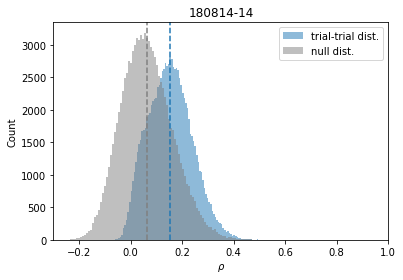

In [7]:
alpha = 0.5
bins = 100
for sess in selected_sess_ch.keys():
    channels = selected_sess_ch[sess]
    for ch in channels:
        # plt.figure(figsize=(2, 2.5))
        plt.hist(session_norm_dist[sess][:,ch], color='tab:blue', alpha=alpha, bins=bins, label='trial-trial dist.')
        plt.hist(session_null_dist[sess][:,ch], color='gray', alpha=alpha, bins=bins, label='null dist.')
        plt.axvline(np.mean(session_norm_dist[sess][:,ch]), color='tab:blue', linestyle='--')
        plt.axvline(np.mean(session_null_dist[sess][:,ch]), color='gray', linestyle='--')
        # plt.axvline(0.0, color='red', linestyle='--')

        plt.xlim(-0.3, 1.0)
        plt.title(f'{sess}-{ch}')
        plt.xlabel(f"$\\rho$")
        plt.ylabel('Count')
        plt.legend()
        gap = sess_ch_gaps[f"{sess}-{ch}"]
        filepath = os.path.join(
            results_dir,
            'tikz_plots',
            f"norm-dist-gap-{gap}.tex"
            )
        PlotterUtils.save_tikz(filepath)
        plt.show()